# SPA detection post-processing

## Import packages

In [188]:
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import sem
import seaborn as sns
from tqdm.notebook import tqdm

plt.style.use(['seaborn-dark', 'notebook'])

## Signal size and linewidth for different R-branch transitions

### Load data

In [49]:
def load_data(fname: str, n_gamma: int = 1) -> pd.DataFrame:
    """
    Loads data from csv and makes some new columns.
    """
    df =  pd.read_csv(fname, skiprows = 2)
    column_names = ['laser_detuning', 'n_photons', 'n_photons_sem']
    mapper = {old_name:new_name for old_name, new_name in zip(df.columns,column_names)}
    df.rename(columns = mapper, inplace = True)
    df['detuning_MHz'] = df.laser_detuning/(2*np.pi*1e6)
    
    df['norm_signal'] = df['n_photons']/n_gamma
    df['norm_signal_sem'] = df['n_photons_sem']/n_gamma
    
    return df


In [87]:
# df_R0F2 = load_data("./saved_data/R(0),_F'=2_bs_agg_n_traj=100_n_bs=100_2022-05-24_18-15-49.csv", n_gamma = 1.92)
# df_R1F3 = load_data("./saved_data/R(1)_F'=3_bs_agg_n_traj=100_n_bs=100_2022-05-24_20-48-39.csv", n_gamma = 2.1)
# df_R2F4 = load_data("./saved_data/R(2)_F'=4_bs_agg_n_traj=100_n_bs=100_2022-05-25_00-47-42.csv", n_gamma = 2.13)

df_R0F2 = load_data("./saved_data/R(0),_F'=2_bs_agg_n_traj=100_n_bs=100_2022-05-24_18-15-49.csv", n_gamma = .904)
df_R1F3 = load_data("./saved_data/R(1)_F'=3_bs_agg_n_traj=100_n_bs=100_2022-05-24_20-48-39.csv", n_gamma = .970)
df_R2F4 = load_data("./saved_data/R(2)_F'=4_bs_agg_n_traj=100_n_bs=100_2022-05-25_00-47-42.csv", n_gamma = .955)

Numbers of photons at resonance:
R(0), F' = 2: 0.904
R(1), F' = 3: 0.970
R(2), F' = 4: 0.955


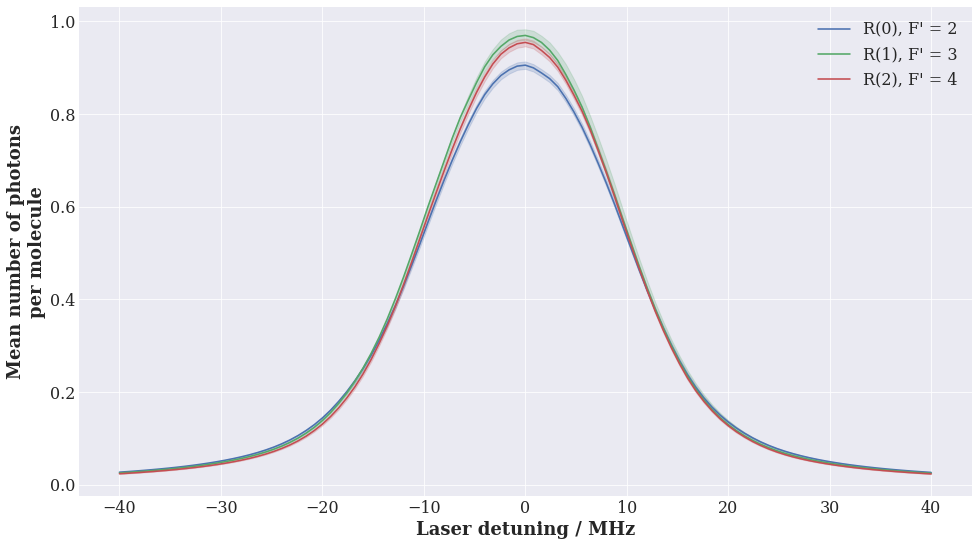

In [88]:
fig, ax = plt.subplots()
ax.plot(df_R0F2.detuning_MHz, df_R0F2.n_photons, color = 'C0', label = "R(0), F' = 2")
ax.fill_between(df_R0F2.detuning_MHz, df_R0F2.n_photons-df_R0F2.n_photons_sem, df_R0F2.n_photons+df_R0F2.n_photons_sem, color = 'C0', alpha = 0.2)
ax.plot(df_R1F3.detuning_MHz, df_R1F3.n_photons, color = 'C1', label = "R(1), F' = 3")
ax.fill_between(df_R1F3.detuning_MHz, df_R1F3.n_photons-df_R1F3.n_photons_sem, df_R1F2.n_photons+df_R1F3.n_photons_sem, color = 'C1', alpha = 0.2)
ax.plot(df_R2F4.detuning_MHz, df_R2F4.n_photons, color = 'C2', label = "R(2), F' = 4")
ax.fill_between(df_R2F4.detuning_MHz, df_R2F4.n_photons-df_R2F4.n_photons_sem, df_R2F4.n_photons+df_R2F4.n_photons_sem, color = 'C2', alpha = 0.2)
ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Mean number of photons\nper molecule')
ax.legend()
print("Numbers of photons at resonance:")
print(f"R(0), F' = 2: {df_R0F1.n_photons.max():.3f}")
print(f"R(1), F' = 3: {df_R1F3.n_photons.max():.3f}")
print(f"R(2), F' = 4: {df_R2F4.n_photons.max():.3f}")

Maximum normalized signal sizes:
R(0), F' = 2: 1.002
R(1), F' = 3: 1.000
R(2), F' = 4: 1.000


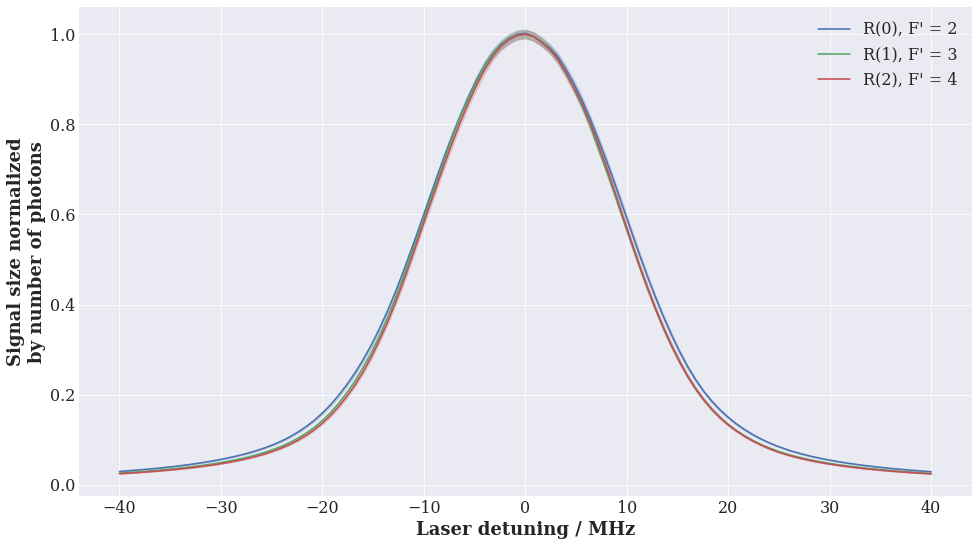

In [92]:
fig, ax = plt.subplots()
ax.plot(df_R0F2.detuning_MHz, df_R0F2.norm_signal, color = 'C0', label = "R(0), F' = 2")
ax.fill_between(df_R0F2.detuning_MHz, df_R0F2.norm_signal-df_R0F2.norm_signal_sem, df_R0F2.norm_signal+df_R0F2.norm_signal_sem, color = 'C0', alpha = 0.2)
ax.plot(df_R1F3.detuning_MHz, df_R1F3.norm_signal, color = 'C1', label = "R(1), F' = 3")
ax.fill_between(df_R1F3.detuning_MHz, df_R1F3.norm_signal-df_R1F3.norm_signal_sem, df_R1F3.norm_signal+df_R1F3.norm_signal_sem, color = 'C1', alpha = 0.2)
ax.plot(df_R2F4.detuning_MHz, df_R2F4.norm_signal, color = 'C2', label = "R(2), F' = 4")
ax.fill_between(df_R2F4.detuning_MHz, df_R2F4.norm_signal-df_R2F4.norm_signal_sem, df_R2F4.norm_signal+df_R2F4.norm_signal_sem, color = 'C2', alpha = 0.2)
ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Signal size normalized\nby number of photons')
ax.legend()

print("Maximum normalized signal sizes:")
print(f"R(0), F' = 2: {df_R0F2.norm_signal.max():.3f}")
print(f"R(1), F' = 3: {df_R1F3.norm_signal.max():.3f}")
print(f"R(2), F' = 4: {df_R2F4.norm_signal.max():.3f}")

### What is the lineshape?
Try fitting a Voigt-lineshape to the simulated data to see if it matches well

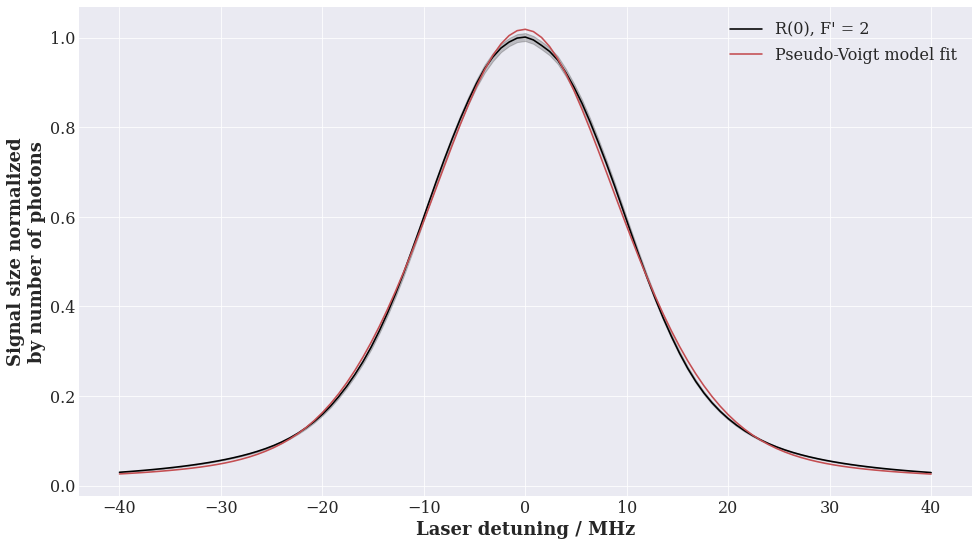

In [210]:
fig, ax = plt.subplots()

# Plot data
ax.plot(df_R0F2.detuning_MHz, df_R0F2.norm_signal, color = 'k', label = "R(0), F' = 2")
ax.fill_between(df_R0F2.detuning_MHz, df_R0F2.norm_signal-df_R0F2.norm_signal_sem, df_R0F2.norm_signal+df_R0F2.norm_signal_sem, color = 'k', alpha = 0.2)

# # Fit and plot model
# model = lmfit.models.DampedOscillatorModel()
# params = model.guess(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz)
# fit_result = model.fit(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz, params = params)
# ax.plot(df_R0F2.detuning_MHz, fit_result.best_fit, color = 'C1', label = "Model fit")

# # Fit and plot model
# model = lmfit.models.VoigtModel()
# params = model.guess(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz)
# fit_result = model.fit(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz, params = params)
# ax.plot(df_R0F2.detuning_MHz, fit_result.best_fit, color = 'C1', label = "Voigt model fit")

# Fit and plot model
model = lmfit.models.PseudoVoigtModel()
params = model.guess(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz)
fit_result = model.fit(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz, params = params)
ax.plot(df_R0F2.detuning_MHz, fit_result.best_fit, color = 'C2', label = "Pseudo-Voigt model fit")

# # Fit and plot model
# model = lmfit.models.MoffatModel()
# params = model.guess(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz)
# fit_result = model.fit(df_R0F2.norm_signal, x = df_R0F2.detuning_MHz, params = params)
# ax.plot(df_R0F2.detuning_MHz, fit_result.best_fit, color = 'C3', label = "Moffat model fit")

ax.set_xlabel('Laser detuning / MHz')
ax.set_ylabel('Signal size normalized\nby number of photons')
ax.legend()

In [211]:
fit_result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,28.4860546,0.13116831,(0.46%),39.39548066233829,-inf,inf,True,
center,-0.10083595,0.02858827,(28.35%),-0.3999999999999975,-inf,inf,True,
sigma,11.2989036,0.04519315,(0.40%),10.800000000000004,0.00000000,inf,True,
fraction,0.43239282,0.01381177,(3.19%),0.5,0.00000000,1.00000000,True,
fwhm,22.5978072,0.09038630,(0.40%),21.60000000000001,-inf,inf,False,2.0000000*sigma
height,1.01917005,0.00281730,(0.28%),1.437257524955117,-inf,inf,False,"(((1-fraction)*amplitude)/max(1e-15, (sigma*sqrt(pi/log(2))))+(fraction*amplitude)/max(1e-15, (pi*sigma)))"


## Center of fluorescence
### Loading raw bootstrap data

In [96]:
def load_bs_data(fname: str, n_gamma: int = 1) -> pd.DataFrame:
    """
    Loads data from csv and makes some new columns.
    """
    df =  pd.read_csv(fname, skiprows = 1)
    df['detuning_MHz'] = df.laser_detuning/(2*np.pi*1e6)
    
    df['norm_signal'] = df['n_photons']/n_gamma
    
    return df

In [97]:
df_R0F2_raw = load_bs_data("./saved_data/R(0),_F'=2_bs_raw_n_traj=100_n_bs=100_2022-05-24_18-15-49.csv", n_gamma = 1.92)
df_R1F3_raw = load_bs_data("./saved_data/R(1)_F'=3_bs_raw_n_traj=100_n_bs=100_2022-05-24_20-48-39.csv", n_gamma = 2.1)
df_R2F4_raw = load_bs_data("./saved_data/R(2)_F'=4_bs_raw_n_traj=100_n_bs=100_2022-05-25_00-47-42.csv", n_gamma = 2.13)

### Calculate weighted mean position of fluorescence for each detuning

In [212]:
def calculate_mean_xpos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the weighted mean x-position for fluorescence, grouped by laser detuning
    """
    pos_dict = dict(detuning=[], x_mean = [])

    for detuning, data in df.groupby('detuning_MHz'):
        pos_dict['detuning'].append(detuning)

        x_mean = np.sum(data.x*data.n_photons)/data.n_photons.sum()
        pos_dict['x_mean'].append(x_mean)

    return pd.DataFrame(pos_dict)

def bootstrap_mean_xpos(df:pd.DataFrame, n_bs = 2) -> pd.DataFrame:
    df_bs = pd.DataFrame()
    
    for n in tqdm(range(n_bs)):
        # Choose trajectories randomly
        traj_idxs = np.random.choice(df['index'].unique(), 100, replace = False)
        
        df_pos = calculate_mean_xpos(df[df['index'].isin(traj_idxs)])
        
        df_bs = pd.concat([df_bs, df_pos])
        
    return df_bs.reset_index(drop = True)

def aggregate_bootstrap(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby('detuning').agg([np.mean, sem]).reset_index()

In [213]:
df_pos_R0F2 = bootstrap_mean_xpos(df_R0F2_raw, n_bs = 100)
df_pos_R1F3 = bootstrap_mean_xpos(df_R1F3_raw, n_bs = 100)
df_pos_R2F4 = bootstrap_mean_xpos(df_R2F4_raw, n_bs = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'Laser detuning / MHz (UV)')

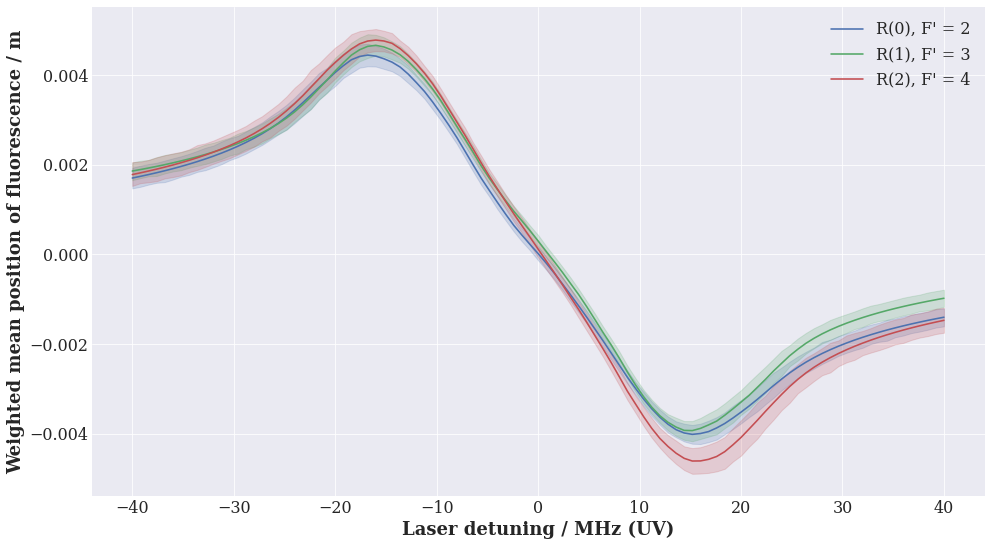

In [214]:
ax = sns.lineplot(data = df_pos_R0F2, x = 'detuning', y = 'x_mean', label = "R(0), F' = 2")
ax = sns.lineplot(data = df_pos_R1F3, x = 'detuning', y = 'x_mean', label = "R(1), F' = 3")
ax = sns.lineplot(data = df_pos_R2F4, x = 'detuning', y = 'x_mean', label = "R(2), F' = 4")
ax.set_ylabel('Weighted mean position of fluorescence / m')
ax.set_xlabel('Laser detuning / MHz (UV)')